This is a model from https://www.kaggle.com/code/nakulsingh1289/face-expression-detection-from-scratch/notebook

modified to meet a more modern keras style and improved coding style

## Image augmentation using keras ImageDataGenerator

In [1]:
# building data generator
from keras.preprocessing.image import ImageDataGenerator

base_path = "./images/"
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(48, 48),
    subset="training",
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = valid_datagen.flow_from_directory(
    base_path + 'train',
    target_size=(48, 48),
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size
)

test_data_generator = test_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
)


2022-10-17 14:16:00.367991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 14:16:00.465320: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 14:16:00.845795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.1/targets/x86_64-linux/lib:/usr/local/cuda-11.7/targets/x86_64-linux/lib
2022-10-17 14:16:00.845839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining our 4 Convolution and 2 Dense layers model

In [2]:
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
from keras.models import Sequential
from keras.applications import EfficientNetB0
from keras.optimizers import Adam
from keras import optimizers, layers

# number of possible label values
nb_classes = 7
IMAGE_SIZE = 48

base_model = EfficientNetB0(input_shape=(
    48, 48, 3), include_top=False, weights="imagenet")
# for layer in base_model.layers[:-4]:
#     layer.trainable=False

model = Sequential([
    base_model,
    Dropout(0.5),
    Flatten(),
    BatchNormalization(),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax'),
])
model.summary()

# opt = SGD(lr=0.01)
# model.compile(loss="categorical_crossentropy",
#               optimizer=opt, metrics=['accuracy'])

model.compile(Adam(lr=0.01), loss='categorical_crossentropy')


2022-10-17 14:16:01.897285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 14:16:01.921913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 14:16:01.922061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 14:16:01.922419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 dropout (Dropout)           (None, 2, 2, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 batch_normalization (BatchN  (None, 5120)             20480     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                163872    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

/home/huukhang1512/.local/share/virtualenvs/CSCI218Project-Temd_YmO/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(verbose=1,patience=20)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=20, min_lr=1e-10)

In [4]:
# number of epochs to train the NN
from keras.callbacks import ModelCheckpoint
epochs = 50

# checkpoint to save best model

# checkpoint = ModelCheckpoint("model.h5")
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr,es],
    verbose=1
)

Epoch 1/50


2022-10-17 14:16:08.700769: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


361/361 [==============================] - 30s 66ms/step - loss: 1.8303 - val_loss: 1.8096 - lr: 0.0100
Epoch 2/50
361/361 [==============================] - 22s 62ms/step - loss: 1.7974 - val_loss: 4.3822 - lr: 0.0100
Epoch 3/50
361/361 [==============================] - 22s 62ms/step - loss: 1.7833 - val_loss: 1.8332 - lr: 0.0100
Epoch 4/50
361/361 [==============================] - 22s 62ms/step - loss: 1.7587 - val_loss: 29.8418 - lr: 0.0100
Epoch 5/50
361/361 [==============================] - 22s 62ms/step - loss: 1.7161 - val_loss: 6.4589 - lr: 0.0100
Epoch 6/50
361/361 [==============================] - 22s 62ms/step - loss: 1.6613 - val_loss: 1.9331 - lr: 0.0100
Epoch 7/50
361/361 [==============================] - 23s 62ms/step - loss: 1.6037 - val_loss: 3.2534 - lr: 0.0100
Epoch 8/50
361/361 [==============================] - 22s 62ms/step - loss: 1.5645 - val_loss: 1.8821 - lr: 0.0100
Epoch 9/50
361/361 [==============================] - 23s 63ms/step - loss: 1.5294 - val_l

In [ ]:
from matplotlib import pyplot as plt

# visualise training and testing accuracy and loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# print best epoch with best accuracy on validation
def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc = max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))

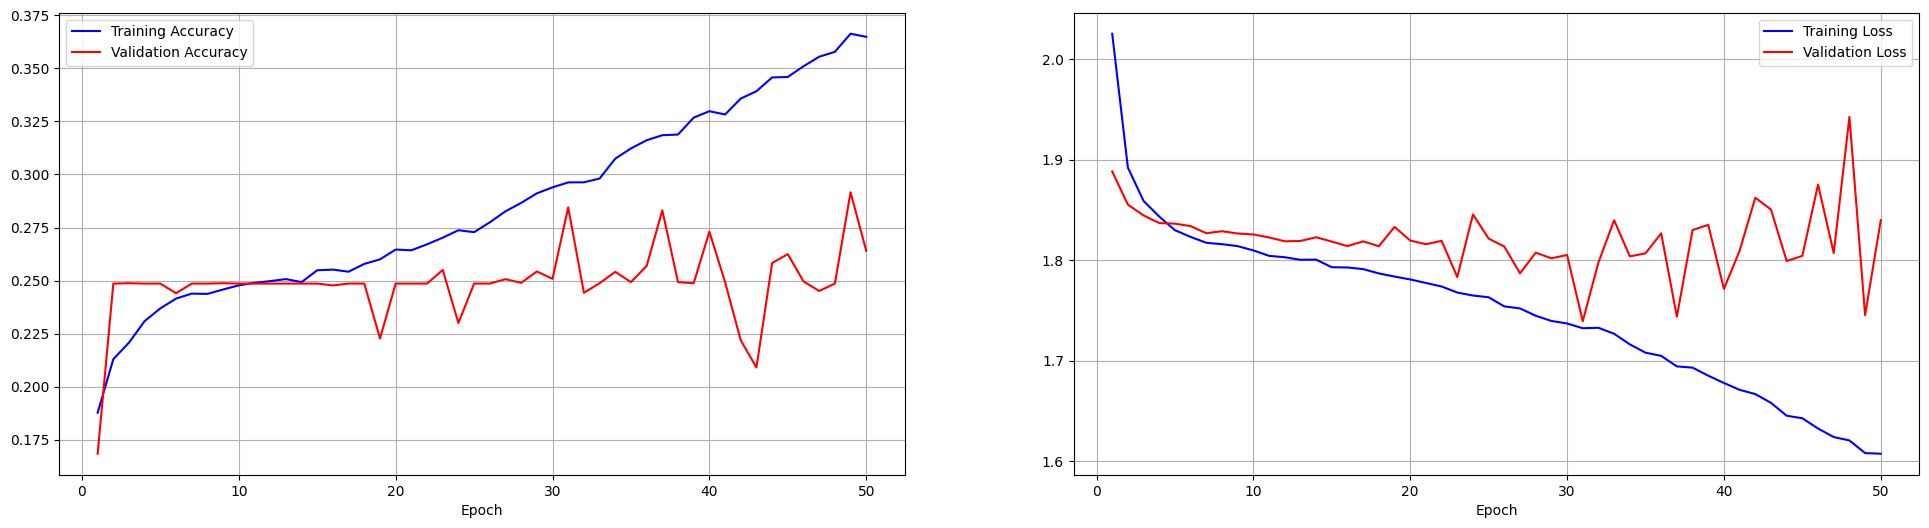

Best Validation Accuracy Score 0.29162, is for epoch 49


In [ ]:
plot_results(history)
get_best_epoch(history)